In [ ]:
pip install datasets

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
# Vocab dictionary
word_index = {}
# Model parameters
embedding_dim = 300
hidden_dim = 128

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [6]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

In [7]:
def encode_label(tags):
    global label_encoding
    return [label_encoding[tag] for tag in tags]

def build_vocab(dataset):
    global  word_index
    for item in dataset['tokens']:
        for word in item:
            if word not in word_index:
                word_index[word] = len(word_index)
    return word_index

In [8]:
word_index = build_vocab(train_dataset)
word_index = build_vocab(val_dataset)
word_index = build_vocab(test_dataset)

## Define the Bi-LSTM model

In [9]:
# LSTM model
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tags):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, tags)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.fc(lstm_out)
        return torch.log_softmax(lstm_out, dim=-1)

In [10]:
# Encode strings and return tensor
def encode_sequence(seq, encoder=None):
    if type(seq[0]) == int:
        encoded_ids = seq
    else:
        encoded_ids = [encoder[word] for word in seq]
    return torch.tensor(encoded_ids, dtype=torch.long)

In [11]:
# def evaluate(model, token_dataset, word_index):
#     model.eval()
#     y_true = []
#     y_pred = []
#     tokens_list = []

#     with torch.no_grad():
#         for i, datapoint in enumerate(token_dataset):
#             tokens = datapoint['tokens']
#             inputs = encode_sequence(tokens, word_index)
#             targets = encode_sequence(encode_label(datapoint['ner_tags']))
#             tag_scores = model(inputs.unsqueeze(0))

#             predicted_tags = tag_scores.max(-1)[1].squeeze().tolist()
#             y_pred.extend(predicted_tags)
#             y_true.extend(targets.tolist())
#             tokens_list.extend(tokens)

#     # Performance metrics
#     labels_indices = list(label_encoding.values())
#     labels_names = list(label_encoding.keys())
#     print(classification_report(y_true, y_pred, labels=labels_indices, target_names=labels_names))

#     overall_f1 = f1_score(y_true, y_pred, average='macro')
#     overall_precision = precision_score(y_true, y_pred, average='macro')
#     overall_recall = recall_score(y_true, y_pred, average='macro')
#     print(f'Overall F1 Score: {overall_f1}')
#     print(f'Overall Precision Score: {overall_precision}')
#     print(f'Overall Recall Score: {overall_recall}')

#     # Confusion matrix
#     cm = confusion_matrix(y_true, y_pred, labels=labels_indices)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names)
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title("Confusion Matrix for NER-tags")
#     plt.show()

#     # Create DataFrame and return the first 15 entries
#     df = pd.DataFrame({
#         "Token": tokens_list,
#         "True Tag": [reverse_label_mapping[tag] for tag in y_true],
#         "Predicted Tag": [reverse_label_mapping[tag] for tag in y_pred]
#     })

#     # return df.head(5000)

In [12]:
# Evaluate the model
def evaluate(model, token_dataset, word_index):
    global label_encoding
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, datapoint in enumerate(token_dataset):
            inputs = encode_sequence(datapoint['tokens'], word_index)
            targets = encode_sequence(encode_label(datapoint['ner_tags']))
            tag_scores = model(inputs.unsqueeze(0))

            predicted_tags = tag_scores.max(-1)[1].squeeze().tolist()
            y_pred.extend(predicted_tags)
            y_true.extend(targets.tolist())

    # Performance metrics
    labels_indices = list(label_encoding.values())
    labels_names = list(label_encoding.keys())
    print(classification_report(y_true, y_pred, labels=labels_indices, target_names=labels_names))

    overall_f1 = f1_score(y_true, y_pred, average= 'macro')
    overall_precision = precision_score(y_true, y_pred, average='macro')
    overall_recall = recall_score(y_true, y_pred, average='macro')
    print(f'Overall F1 Score: {overall_f1}')
    print(f'Overall Precision Score: {overall_precision}')
    print(f'Overall Recall Score: {overall_recall}')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[labels_indices])
    disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names) # adjust cmap if needed
    disp.set_xlabel("Predicted Label")
    disp.set_ylabel("True Label")
    disp.set_title("Confusion Matrix for NER-tags")
    plt.show()

## Training the model

              precision    recall  f1-score   support

         B-O       0.93      0.97      0.95      4292
        B-AC       0.76      0.43      0.55       270
        B-LF       0.57      0.43      0.49       150
        I-LF       0.68      0.57      0.62       288

    accuracy                           0.90      5000
   macro avg       0.74      0.60      0.65      5000
weighted avg       0.90      0.90      0.90      5000

Overall F1 Score: 0.651669610285076
Overall Precision Score: 0.7352749392080522
Overall Recall Score: 0.5989851165820994


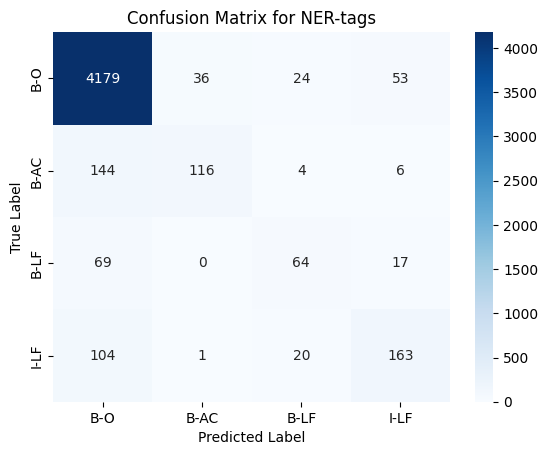

In [13]:
# Training the model
model = LSTM(embedding_dim, hidden_dim, len(word_index), 4)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.9)

for epoch in range(6):
    for i, datapoint in enumerate(train_dataset):
        model.zero_grad()
        sentence_in = encode_sequence(datapoint['tokens'], word_index)
        targets = encode_sequence(encode_label(datapoint['ner_tags']))
        tag_scores = model(sentence_in.unsqueeze(0))
        loss = loss_function(tag_scores.squeeze(0), targets)
        loss.backward()
        optimizer.step()
        # if i == 199:break

    # Model Validation
    model.eval()
    with torch.no_grad():
        for val_datapoint in val_dataset:
            val_inputs = encode_sequence(val_datapoint['tokens'], word_index)
            val_targets = encode_sequence(encode_label(val_datapoint['ner_tags']))
            val_tag_scores = model(val_inputs.unsqueeze(0))
            val_loss = loss_function(val_tag_scores.squeeze(0), val_targets)

    model.train()

# Evaluate on the test set
evaluate(model, test_dataset, word_index)